In [ ]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator3 import calibrate
from matrix_helper import *
import matplotlib.pyplot as plt
import pandas as pd
dob = dobbellogger()

In [37]:
q_rot = np.array([-0.22758238, -0.66122331, -0.6738042, 0.23870041])
cali = calibrate(dob, 2, 1, 100, 2, 125, q_rot)
acc_std = cali['acc std']
gyro_std = cali['gyro std']
print(cali)

Leg de dobbelsteen met nummer  1  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  4  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  5  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  6  boven
Wacht 1 secondes
Logging data for 2s
Done! The data is located in self.datadf
{'gyro bias': array([ 0.4494553 , -0.12481477,  0.05589055]), 'gyro std': array([0.04623529, 0.06378063, 0.05948078]), 'acc values': array([ 0.99333502, -1.00794565,  1.00001939, -1.00483598,  1.02605969,
       -1.01022587]), 'acc std': array([0.001073  , 0.0011066 , 0.00117693, 0.00233057,

In [2]:
cali = {'gyro bias': np.array([ 0.4494553 , -0.12481477,  0.05589055]), 'gyro std': np.array([0.04623529, 0.06378063, 0.05948078]), 'acc values': np.array([ 0.99333502, -1.00794565,  1.00001939, -1.00483598,  1.02605969, -1.01022587]), 'acc std': np.array([0.001073  , 0.0011066 , 0.00117693, 0.00233057, 0.00178357, 0.00134386])}
q_rot = np.array([-0.22758238, -0.66122331, -0.6738042, 0.23870041])
acc_std = cali['acc std']
gyro_std = cali['gyro std']

In [142]:
dob.connect()
dob.log(10, 100, 4, 2000)
dob.download()
data_with_bias = dob.datadf

Logging data for 10s
Done! The data is located in self.datadf


In [143]:
data = remove_nan(data_with_bias)
data = rotate_data(data, q_rot)
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 4960.383629191321
x_acc -0.02563977208270033
y_acc 0.004009460853753446
z_acc 1.048044007241397
x_gyro 0.45717589576017154
y_gyro -0.12825816990399916
z_gyro 0.0656829286851926


In [144]:
# Deze code niet vaker dan 1 keer uitvoeren!
# data = remove_nan(data)
# data = rotate_data(data, q_rot)
data = remove_bias(data, cali)

In [145]:
for column in data.columns:
    print(column, np.mean(data[column]))

timestamp 4960.383629191321
x_acc -0.018322724400971054
y_acc 0.00640221329656652
z_acc 1.021592568029994
x_gyro 0.007720595760171559
y_gyro -0.0034433999039991565
z_gyro 0.009792378685192591


In [146]:
data.head()

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.016938,0.007965,1.022129,0.103984,-0.097613,0.036829
1,19.0,-0.021437,0.007491,1.016882,0.041778,0.048871,-0.220035
2,21.0,-0.021264,0.007619,1.019872,0.035230,0.064290,-0.247074
3,30.0,-0.020488,0.008196,1.033327,-0.081572,-0.004320,-0.035280
4,40.0,-0.018239,0.008262,1.012717,-0.016592,-0.146738,0.077303


In [147]:
y11 = np.array([np.mean(data['x_acc'][0:10]), np.mean(data['y_acc'][0:10]), np.mean(data['z_acc'][0:10])])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
ymb= np.array([1, 2, 3])
mb = np.array([1, 0, 0]) #np.cross(gb, np.cross(ymb / np.linalg.norm(ymb), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]
q11 = max_eigenvector

In [148]:
q11 = max_eigenvector

dqde = np.array([
    [0,0,0],
    [1,0,0],
    [0,1,0],
    [0,0,1]
])

sigma_etha = np.array([
    [(np.pi / 9) ** 2, 0, 0],
    [0, (np.pi / 9) ** 2, 0],
    [0, 0, (np.pi / 9) ** 2]
])

P11_rot = 0.25 * np.matmul(np.matmul(np.matmul(np.matmul(right_quat_mul(q11), dqde), sigma_etha), dqde.T), right_quat_mul(q11))
v11 = np.array([0,0,0])
p11 = np.array([0,0,0])

In [149]:
Q_gyro = np.array([
    [gyro_std[0] ** 2, 0, 0],
    [0, gyro_std[1] ** 2, 0],
    [0, 0, gyro_std[2] ** 2]
])
Q_pv_std = 0.0001
Q_pv = Q_pv_std * np.eye(6)
Q = np.vstack([np.hstack([Q_pv, np.zeros((6, 3))]), np.hstack([np.zeros((3, 6)), Q_gyro])])

small_R = 10 * np.array([
    [acc_std[0] ** 2, 0, 0],
    [0, acc_std[1] ** 2, 0],
    [0, 0, acc_std[2] ** 2],
])

R_pzv_std = 0.0001
R_pzv = R_pzv_std * np.eye(4)
large_R = np.vstack([np.hstack([R_pzv, np.zeros((4, 3))]), np.hstack([np.zeros((3, 4)), small_R])])

Ppvstd = 0.01
P11 = np.vstack([np.hstack([Ppvstd * np.eye(6), np.zeros((6, 4))]), np.hstack([np.zeros((4, 6)), P11_rot])])

#P11 = np.vstack([np.zeros((6,10)), np.hstack([np.zeros((4, 6)), P11_rot])])

In [150]:
print(P11)

[[ 1.00000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e-02
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  1.00000000e-02  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00

In [151]:
zv_data = zv_checker(data, 5, 0.05)
print(len(zv_data))
count = 0
for bool in zv_data['zero velocity']:
    if bool:
        count += 1
print(count)
print(list(zv_data['zero velocity']))

1014
1004
[False, False, False, False, False, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, 

In [178]:
xtmin1tmin1 = np.concatenate([p11, v11, q11])
Ptmin1tmin1 = P11

x_list = [xtmin1tmin1]
epsilon_list = []
yan_list = []
yab_list = []


for i in range(1, len(zv_data['timestamp'])):
    dt = (zv_data['timestamp'][i] - zv_data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([zv_data['x_gyro'][i], zv_data['y_gyro'][i], zv_data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)

    ptmin1tmin1 = xtmin1tmin1[:3]
    vtmin1tmin1 = xtmin1tmin1[3:6]
    qtmin1tmin1 = xtmin1tmin1[6:]

    yat_b = np.array([zv_data['x_acc'][i], zv_data['y_acc'][i], zv_data['z_acc'][i]])
    yat_n = rotate_vector(gn, quaternion_conjugate(np.reshape(qtmin1tmin1, 4)))
    yan_list.append(yat_n)
    yab_list.append(yat_b)
    
    pttmin1 = ptmin1tmin1 + dt * vtmin1tmin1 + 0.5 * (yat_n - gn) * 9.81 * dt ** 2
    vttmin1 = vtmin1tmin1 + dt * (yat_n - gn) * 9.81
    qttmin1 = quat_mul(qtmin1tmin1, expq_omega)
    
    xttmin1 = np.concatenate([pttmin1, vttmin1, qttmin1])

    Ftmin1 = calculate_F(xttmin1, omega, yat_b * 9.81, dt)
    Gtmin1 = calculate_G(xttmin1, dt)
    Pttmin1 = np.matmul(np.matmul(Ftmin1, Ptmin1tmin1), Ftmin1.T) + np.matmul(np.matmul(Gtmin1, Q), Gtmin1.T)
    
    if False: #zv_data['zero velocity'][i]:
        H = calculate_large_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + large_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        yateps_rot = yat_b #/ np.linalg.norm(yat_b)
        yattmin1_rot = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon_rot = yateps_rot - yattmin1_rot
        ypzv_est = np.array([pttmin1[2], *vttmin1])
        ypzv_mea = np.zeros(4)
        epsilon_pos = np.reshape(ypzv_mea - ypzv_est, (4, 1))
        epsilon = np.vstack([epsilon_pos, np.reshape(epsilon_rot, (3, 1))])
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)
    else:
        H = calculate_small_H(xttmin1)
        S = np.matmul(np.matmul(H, Pttmin1), H.T) + small_R
        K = np.matmul(np.matmul(Pttmin1, H.T), np.linalg.inv(S))
        yateps = yat_b #/ np.linalg.norm(yat_b)
        yattmin1 = rotate_vector(gn, quaternion_conjugate(np.reshape(qttmin1, 4)))
        epsilon = np.reshape(yateps - yattmin1, (3, 1))
        x_tt_measure = np.reshape(xttmin1, (10, 1)) + np.matmul(K, epsilon)

    epsilon_list.append(epsilon)

    Ptt = Pttmin1 - np.matmul(np.matmul(K, H), Pttmin1)
    x_tt_measure = np.reshape(x_tt_measure, 10)
    x_tt = np.concatenate([x_tt_measure[:6], x_tt_measure[6:] / np.linalg.norm(x_tt_measure[6:])])
    
    Ptmin1tmin1 = Ptt
    xtmin1tmin1 = x_tt
    x_list.append(x_tt)

x_array = np.reshape(np.concatenate(x_list), (len(x_list), 10))
results = pd.DataFrame(x_array, columns=['px', 'py', 'pz', 'vx', 'vy', 'vz', 'q0', 'q1', 'q2', 'q3'])
results.head(1000)

,px,py,pz,vx,vy,vz,q0,q1,q2,q3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.999982,-0.003769,-0.004561,0.000017
1,0.000899,-0.000151,0.000011,0.094595,-0.015851,0.001127,-0.999962,-0.003502,-0.007522,-0.002515
2,0.001088,-0.000182,0.000013,0.094313,-0.015731,0.001125,-0.999962,-0.003502,-0.007528,-0.002510
3,0.001931,-0.000321,0.000023,0.092985,-0.015109,0.001113,-0.999962,-0.003502,-0.007597,-0.002508
4,0.002853,-0.000469,0.000034,0.091496,-0.014418,0.001099,-0.999962,-0.003511,-0.007635,-0.002514
...,...,...,...,...,...,...,...,...,...,...
995,-7.284253,2.843925,-0.071698,-1.607683,0.593167,-0.016052,-0.999949,-0.003129,-0.009065,-0.003283
996,-7.300339,2.849860,-0.071859,-1.609460,0.593787,-0.016070,-0.999949,-0.003127,-0.009074,-0.003288
997,-7.318054,2.856395,-0.072036,-1.611416,0.594468,-0.016090,-0.999948,-0.003138,-0.009111,-0.003285
998,-7.334177,2.862343,-0.072197,-1.613201,0.595090,-0.016108,-0.999948,-0.003138,-0.009118,-0.003286


In [179]:
print(quaternion_to_euler(results.iloc[0][6:]) * 180 / np.pi)

[ 0.00393977  0.52265483 -0.43189285]


In [180]:
ans = np.reshape(np.concatenate(yan_list), (int(len(yan_list)), 3))
for i in range(3):
    print(np.mean(ans[:,i]))

-0.01787844450915014
0.00639502544587825
0.9998195585056727


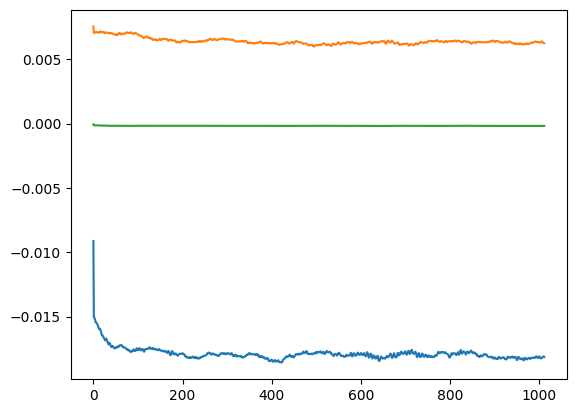

In [202]:
plt.plot(ans[:,0])
plt.plot(ans[:,1])
plt.plot(ans[:,2]-1)
plt.show()

In [182]:
yabs = np.reshape(np.concatenate(yab_list), (int(len(yab_list)), 3))
for i in range(3):
    print(np.mean(yabs[:,i]))

-0.018324090886621156
0.006400670588257796
1.0215920386333381


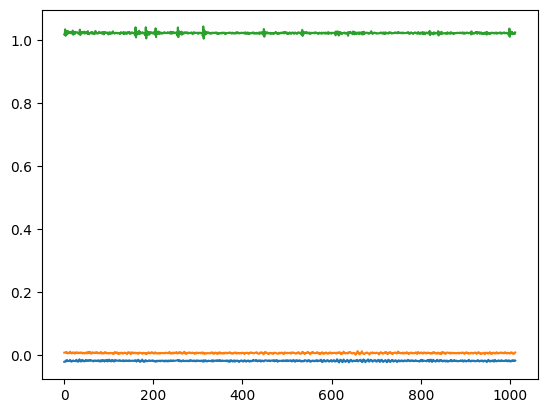

In [183]:
plt.plot(yabs[:,0])
plt.plot(yabs[:,1])
plt.plot(yabs[:,2])
plt.show()

In [184]:
print(np.linalg.norm(np.mean(yabs, axis=0)))

1.021776411104611


In [185]:
plot_x = []
plot_y = []
plot_z = []

for x, timestamp in zip(x_list, data['timestamp']):
    euler = quaternion_to_euler(x[6:]) * 180 / np.pi
    plot_x.append(euler[0])
    plot_y.append(euler[1])
    plot_z.append(euler[2])

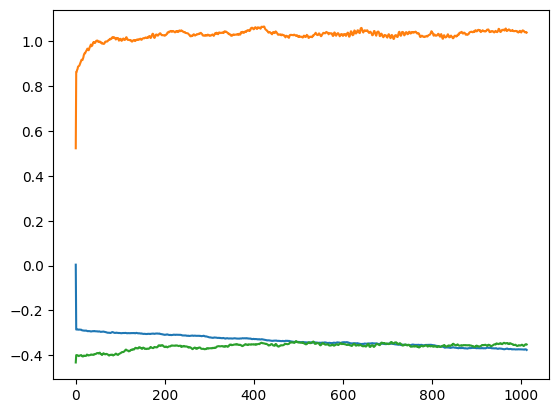

In [186]:
plt.plot(plot_x)
plt.plot(plot_y)
plt.plot(plot_z)

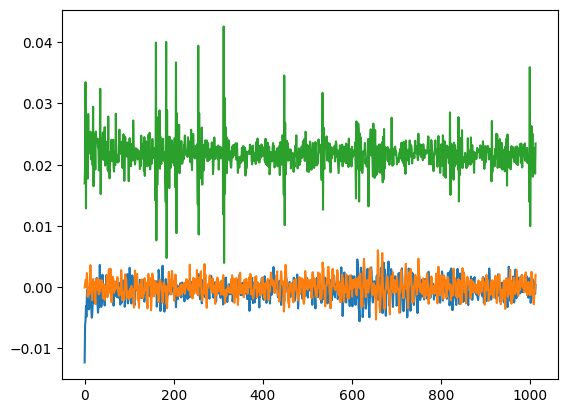

In [187]:
epsilon_rot = []
for e in epsilon_list:
    epsilon_rot.append(e[-3:, 0])
    
epsilons = np.concatenate(epsilon_rot)
epsilons = np.reshape(epsilons, (int(len(epsilons) / 3), 3))

plt.plot(epsilons[:, 0])
plt.plot(epsilons[:, 1])
plt.plot(epsilons[:, 2])

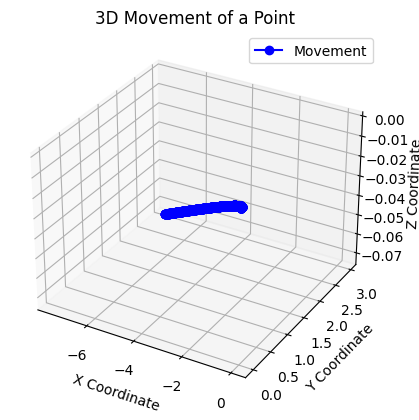

In [188]:
positions = x_array[:,:3]
# Create a new figure for the 3D plot
fig = plt.figure()

# Add a 3D subplot
ax = fig.add_subplot(111, projection='3d')

# Plot the movement of the point
ax.plot(positions[:,0], positions[:,1], positions[:,2], marker='o', linestyle='-', color='b', label='Movement')

# Set labels for each axis
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

# Set a title
ax.set_title('3D Movement of a Point')

# Add a legend
ax.legend()

# Show the plot
plt.show()

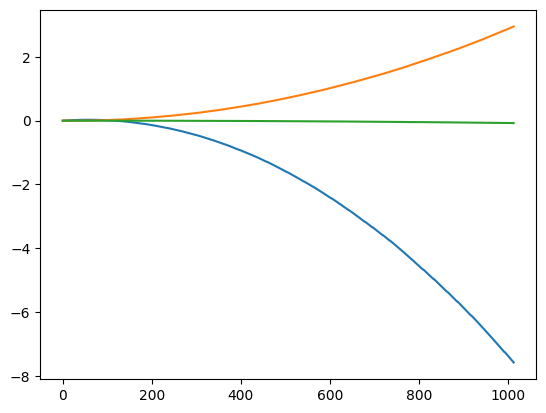

In [189]:
plt.plot(positions[:,0])
plt.plot(positions[:,1])
plt.plot(positions[:,2])
plt.show()

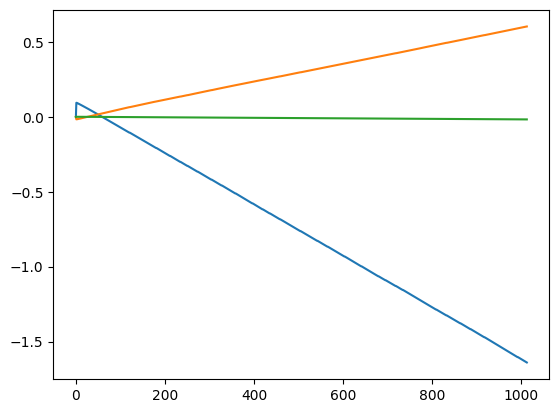

In [201]:
velocities = x_array[:,3:6]
plt.plot(velocities[:, 0])
plt.plot(velocities[:, 1])
plt.plot(velocities[:, 2])
plt.show()

In [193]:
dob.disconnect()

we are disconnected!
